In [2]:
import numpy as np
import random
import pickle
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
import tensorflow as tf
from tensorflow.contrib.layers import flatten
import time
import csv

In [3]:
training_file = './train.p'
testing_file = './test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)

assert(len(train['features']) == len(train['labels']))
assert(len(test['features']) == len(test['labels']))

#A few prints to understand the data
print("'train' and 'test' are dictionaries with keys:", train.keys())
print("'features' in 'train' is a", type(train['features']), "of size", train['features'].shape)
print("'labels' in 'train' is a", type(train['labels']), "of size", train['labels'].shape)
print("'sizes' in 'train' is a", type(train['sizes']), "of size", train['sizes'].shape)
print("'coords' in 'train' is a", type(train['coords']), "of size", train['coords'].shape)

'train' and 'test' are dictionaries with keys: dict_keys(['coords', 'labels', 'features', 'sizes'])
'features' in 'train' is a <class 'numpy.ndarray'> of size (34799, 32, 32, 3)
'labels' in 'train' is a <class 'numpy.ndarray'> of size (34799,)
'sizes' in 'train' is a <class 'numpy.ndarray'> of size (34799, 2)
'coords' in 'train' is a <class 'numpy.ndarray'> of size (34799, 4)


In [4]:
# Number of training, validation, and test examples, image resolution and color channels,
# and number of classification classes
n_train = len(train['features'])
n_test = len(test['features'])
image_shape = train['features'][0,:,:,:].shape

train_unique, train_counts = np.unique(train['labels'], return_counts='True')
test_unique, test_counts = np.unique(test['labels'], return_counts='True')
n_classes_train = len(train_unique)
n_classes_test = len(test_unique)

print("Number of training examples =", n_train)
print("Number of test examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes in the training set =", n_classes_train)
print("Number of classes in the test set =", n_classes_test)

Number of training examples = 34799
Number of test examples = 12630
Image data shape = (32, 32, 3)
Number of classes in the training set = 43
Number of classes in the test set = 43


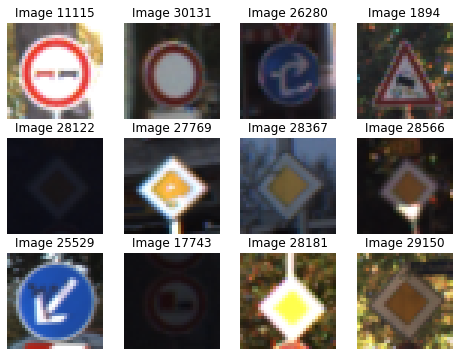

In [5]:
grid_m = 3
grid_n = 4
rand_grid = np.random.randint(n_train, size=[grid_m,grid_n])

f0, cell0 = plt.subplots(grid_m, grid_n, figsize=(8,6))
for i in range(grid_m):
    for j in range(grid_n):
        cell0[i, j].imshow(train['features'][rand_grid[i,j]])
        cell0[i, j].axis('off')
        cell0[i, j].set_title('Image {}'.format(rand_grid[i,j]))

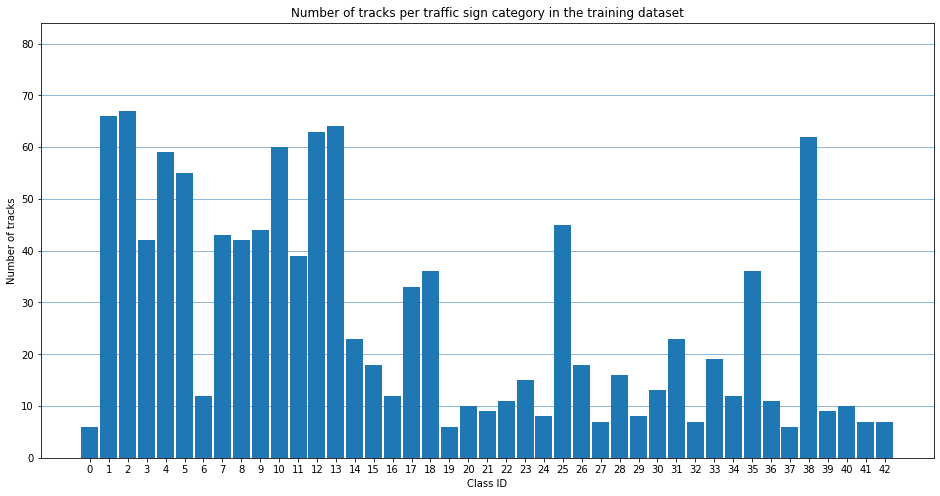

In [6]:
train_pcent = np.around(np.array([i/n_train for i in train_counts])*100, 1)
test_pcent = np.around(np.array([np.around(i/n_test, 3) for i in test_counts])*100, 1)

with open('./signnames.csv', newline='') as csvfile:
    csvread = csv.reader(csvfile, delimiter=',')
    signtable = {i[0]:i[1] for i in csvread}
signnames = [signtable[str(train_unique[i])] for i in train_unique]

n_tracks_train = (train_counts / 30).astype(int)
n_tracks_test = (test_counts / 30).astype(int)

class_table = np.array([train_unique, signnames, n_tracks_train, train_counts, train_pcent, n_tracks_test, test_counts, test_pcent]).T

np.set_printoptions(suppress=True, precision=1) # suppress scientific data format for printing because it's not very readable
#print(['Class Id', 'Desc.', '# Tracks Train', '# Train', '% Train', '# Tracks Test', '# Test', '% Test'])
#print(class_table)

f1, cell1 = plt.subplots(figsize=(16,8))
cell1.bar(range(len(n_tracks_train)), n_tracks_train, width=0.9)
cell1.set_ylabel("Number of tracks")
cell1.set_xlabel("Class ID")
cell1.set_xticks(np.arange(0,43,1))
cell1.set_title("Number of tracks per traffic sign category in the training dataset")
for ymaj in cell1.yaxis.get_majorticklocs():
    cell1.axhline(y=ymaj, linewidth=0.5)

In [7]:
def val_split(features, labels, sizes, coords, n_pick=2, n_imgs_per_track=30):
    '''
    Split off a consistent subset from `features`, `labels`, `sizes`, and `coords`.
    
    The subset set will be constructed as follows: From each class in `labels`, randomly pick `n_pick` complete tracks.
    
    Args:
        features (array-like): A 4-D array containing raw pixel data of the images (num examples, width, height, channels).
        labels (array-like): A 1-D array containing the label/class ID of the image.
        sizes (array-like): A list containing tuples (width, height) representing the the original width and height of the image.
        coords (array-like): A list containing tuples (x1, y1, x2, y2) representing the coordinates of a bounding box
            around the traffic sign in the image.
        n_pick (int): The number of tracks to be picked from `features` for each class in `labels`. The maximum value is 6.
            Defaults to 2.
        n_imgs_per_track (int): The number of images per track in `features`. Defaults to 30.
        
    Returns:
        Eight numpy arrays containing features, labels, sizes, and coords of the same dimensions as their respective
        inputs for each the training and validation datasets.
    '''
    
    #Get the number of classes and the number of samples for each class
    train_unique, train_counts = np.unique(labels, return_counts='True')

    n_tracks = (train_counts / n_imgs_per_track).astype(int) #The number of tracks for any given class
    
    #Calculate a list of the cumulative number of images in all classes *before* a given class 'c'.
    #This is needed to calculate the start and end indices to select one track from each class to be picked
    #for the validation dataset.
    cum_imgs_per_class = np.zeros(len(train_unique), dtype='int')
    for k in range(1, len(train_unique)):
        cum_imgs_per_class[k:] += train_counts[k-1]

    #Collect the selection indices for the validation dataset
    val_indices = np.array([], dtype='int')
    for c in range(len(train_unique)): #For each class...
        val_tracks = random.sample(range(n_tracks[c]), n_pick) #...randomly select 'n_tracks_pick' tracks from that class...
        for k in val_tracks: #...and for each of the selected tracks...
            start = cum_imgs_per_class[c] + n_imgs_per_track * k #...calculate the start and end indices...
            end = start + n_imgs_per_track
            #print("class: ", c, "validation tracks picked: ", validation_tracks, "start: ", start, "end: ", end)
            val_indices = np.hstack((val_indices, np.r_[start:end])) #...and add them to the list and...
    
    #...now create a validation dataset with these indices and...
    val_features = np.take(features, val_indices, 0)
    val_labels = np.take(labels, val_indices, 0)
    val_sizes = np.take(sizes, val_indices, 0)
    val_coords = np.take(coords, val_indices, 0)

    #...create a new training dataset from the old training dataset by removing the validation data.
    train_features = np.take(features, sorted(set(range(len(features)))-set(val_indices)), 0)
    train_labels = np.take(labels, sorted(set(range(len(labels)))-set(val_indices)), 0)
    train_sizes = np.take(sizes, sorted(set(range(len(sizes)))-set(val_indices)), 0)
    train_coords = np.take(coords, sorted(set(range(len(coords)))-set(val_indices)), 0)
    
    return (train_features,
            train_labels,
            train_sizes,
            train_coords,
            val_features,
            val_labels,
            val_sizes,
            val_coords)

In [8]:
train_features, train_labels, train_sizes, train_coords, val_features, val_labels, val_sizes, val_coords = val_split(train['features'],
                                                                                                                     train['labels'],
                                                                                                                     train['sizes'],
                                                                                                                     train['coords'])

#Save it all to disk so that it is deterministic and faster for next time.
np.save('./val_features', val_features)
np.save('./val_labels', val_labels)
np.save('./val_sizes', val_sizes)
np.save('./val_coords', val_coords)

np.save('./train_features', train_features)
np.save('./train_labels', train_labels)
np.save('./train_sizes', train_sizes)
np.save('./train_coords', train_coords)

print("Training and validation datasets created and saved to disk.")
print()

n_train = len(train_features)
n_val = len(val_features)
n_test = len(test['features'])
image_shape = train_features[0,:,:,:].shape
n_classes = len(train_unique)
test_unique = np.unique(test['labels'], return_counts='False')
n_classes_test = len(test_unique)

print("Number of training examples =", n_train)
print("Number of validation examples =", n_val)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes in the training set =", n_classes)
print("Number of classes in the test set =", n_classes_test)

Training and validation datasets created and saved to disk.

Number of training examples = 32219
Number of validation examples = 2580
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes in the training set = 43
Number of classes in the test set = 2


In [9]:
train_features = np.load('./train_features.npy')
train_labels = np.load('./train_labels.npy')
val_features = np.load('./val_features.npy')
val_labels = np.load('./val_labels.npy')

testing_file = './test.p'
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)